In [1]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import random
import PIL

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu


In [2]:
model_name = "squeezenet"
num_classes = 1000
batch_size = 8
num_epochs = 5
feature_extract = True

# Initialize the model for this run
model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_0', pretrained=True).eval()
input_size = 224

Using cache found in C:\Users\islam/.cache\torch\hub\pytorch_vision_v0.6.0


In [4]:
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Initialized Datasets and Dataloaders")

Initialized Datasets and Dataloaders


# Check Our Method

In [16]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetBottom, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())
        
    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[1])
        
    def forward(self, x):
        x = x.view((-1, 512, 13, 13))
        x = self.features(x)
        x = x.view((-1, 1000))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model):    
    model_bottom = SqueezenetBottom(model)
    model_top = SqueezenetTop(model)
    return model_bottom, model_top

model_bottom, model_top = get_model_parts(model_ft)
model_bottom.eval()
model_top.eval();

In [10]:
import pickle
concept_dict = pickle.load(open('sq_concepts_102.pkl', 'rb'))

In [11]:
import requests
response = requests.get("https://git.io/JJkYN")
class_labels = response.text.split("\n")

In [31]:
def get_concept_scores(image, correct_label):
    concept_scores = {}
    image = PIL.Image.open(image)
    image_bg = PIL.Image.open(r"C:\Users\islam\Downloads\black.jpg")
    
    # given an image, load it
    tensor = data_transforms["val"](image).unsqueeze(0)
#     tensor = data_transforms["val"](image).unsqueeze(0)
#     tensor_bg = data_transforms["val"](image_bg).unsqueeze(0)
        
    # just run through and make its prediction for each concept
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
    original_labels = {class_labels[i]: float(original_preds[i]) for i in range(1000)}
    correct_idx = class_labels.index(correct_label)
    
    # modify it in the concept space
    best_diff = float("-inf")
    
    if model_name == "squeezenet":
        multiplier = 100000
    else:
        multiplier = 10000
    
    for key in concept_dict:
        svm, _, _ = concept_dict[key]
        # see which ones cause the most difference in the right direction one by one  
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*svm.coef_).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        neg_preds = model_top(torch.from_numpy(embedding.detach().numpy() - multiplier*svm.coef_).float())
        neg_diff = neg_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key + '+'] = float(plus_diff)
        concept_scores[key + '-'] = float(neg_diff)
        if plus_diff > best_diff:
            best_diff = plus_diff
            best_preds = plus_preds.detach().numpy().squeeze()
        if neg_diff > best_diff:
            best_diff = neg_diff
            best_preds = neg_preds.detach().numpy().squeeze()
        
    concept_scores_list = [(k, concept_scores[k]) for k in sorted(concept_scores, key=concept_scores.get, reverse=True)]
    correct_labels = {class_labels[i]: float(best_preds[i]) for i in range(1000)}
    
    return concept_scores, concept_scores_list

In [54]:
concept_scores, concept_scores_list = get_concept_scores(r'C:\Users\islam\Downloads\zebra-water.jpg', 'zebra')

In [55]:
coefs_array = [concept_dict[key][0].coef_ for key in concept_dict]
coefs_array = np.concatenate(coefs_array)
coefs_array.shape

(102, 86528)

In [58]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

smaller = PCA(n_components=102).fit_transform(coefs_array)
coefs2d = TSNE(n_components=2).fit_transform(smaller)

In [59]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_name('Arial')

In [63]:
key_list, score_list = zip(*concept_scores_list)
n = int(len(key_list)/2)
key_list = key_list[:n]
score_list = score_list[:n]

order = np.argsort(key_list)
key_list = np.array(key_list)[order]
score_list = np.array(score_list)[order]

In [65]:
np.argsort(sizes)

array([ 72,  87,  92,  21,  18,  65,  30,  22,  55,  45,  44,  76,  35,
        33,  25,  32,  47,  27,  66,  80,  89,  84,  17,  57,  74,  88,
        36,  61,  31,  73,   4,  77,  39,  20,   1,  98,  64,  94,  49,
        38,  46,  95,  58,  50,  24,   0,  19,  59,  12,  68,  86,  71,
        96,  93,  23,   5,  14,  62,  15,  75,  63,  70,  41,  13,   8,
        79,  56,  67,  53,  28,  48,  34,   9,  11,  85,  52,  10,   2,
        83,  78,  16,  29,  42,  81,   3,   7,  54,  60,  82,  90,  97,
        26,   6,  37,  51,  43, 100, 101,  40,  99,  69,  91], dtype=int64)

bush


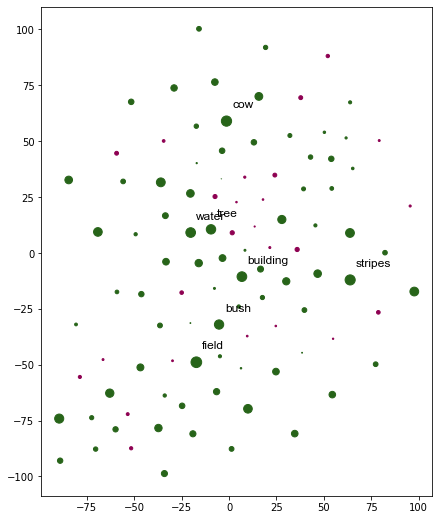

In [68]:
# score_list = np.array(list(scores.values()))
sizes = np.abs(score_list)*300.0

fig, ax = plt.subplots(figsize=[7, 9])
ax.scatter(*coefs2d.T, s=sizes, c=np.sign(score_list), cmap='PiYG')

for i, key in enumerate(key_list):
    if sizes[i] > 86.4:
        key = key[:-1]
        if key == "bush":
            offset = -16
            print("bush")
        else:
            offset = 3
        offset = 3
        ax.annotate(key, (coefs2d[i, 0]+offset, coefs2d[i, 1]+6), fontsize=12, fontproperties=font)

In [70]:
key_list

array(['air_conditioner+', 'air_conditioner-', 'airplane+', 'apron+',
       'arm-', 'armchair-', 'ashcan-', 'awning+', 'back+', 'back_pillow+',
       'bag-', 'balcony+', 'bannister+', 'base-', 'basket-',
       'bathroom_s+', 'bathtub-', 'beak+', 'beak-', 'bed+', 'bed-',
       'bedclothes+', 'bedroom_s-', 'bench+', 'bicycle+', 'bird-',
       'blackness+', 'blind+', 'blotchy+', 'blueness-', 'board+', 'body+',
       'book+', 'bookcase+', 'bottle-', 'box+', 'brick-', 'bridge+',
       'bucket+', 'bucket-', 'building+', 'bumper+', 'bus+', 'bush+',
       'cabinet-', 'can-', 'candlestick+', 'candlestick-', 'canopy+',
       'cap+', 'cap-', 'car+', 'cardboard-', 'carpet-', 'cat+',
       'ceiling-', 'ceramic-', 'chain_wheel+', 'chair+', 'chandelier-',
       'chest_of_drawers-', 'chimney-', 'clock+', 'coach+',
       'coffee_table-', 'computer+', 'computer-', 'counter-',
       'countertop-', 'cow+', 'cup-', 'cushion-', 'desk+', 'desk-',
       'dining_room_s+', 'dog+', 'door-', 'door_f